<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/prep_coronal_hole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sunpy
!pip install aiapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.9/501.9 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.8/195.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.1 MB/s eta 0:00:00
  Created wheel for aiapy: filename=aiapy-0.7.4-py3-none-any.whl size=54821 sha256=9a44d1103e375

Dates of AIA data to read in

In [2]:
dates = ['2010-05-23','2011-05-23','2012-05-27','2013-04-24','2014-05-01','2015-05-23', '2016-05-23','2017-05-23']


Create directories to save into

In [3]:
import os
from os.path import exists

for date in dates:
  path = '/content/drive/MyDrive/sdo_cor_hole_data/'+date
  if not exists(path):
    os.mkdir(path)


In [4]:
from sunpy.net import Fido, attrs
import astropy.units as u

import numpy as np

Download data using sunpy

In [5]:
for date in dates[7:]:
  time = attrs.Time(date+' 01:00:00',date+' 01:00:20')
  res = Fido.search(time, attrs.Instrument.aia, attrs.Wavelength(94*u.Angstrom, 335*u.Angstrom))
  vals = np.where(res[0]['Wavelength'] == 304*u.Angstrom)
  to_get = res[0][vals[0][0]+1:vals[0][0]+7]
  files = Fido.fetch(to_get, path='/content/drive/MyDrive/sdo_cor_hole_data/{}/'.format(date))

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

In [ ]:
files = Fido.fetch(files, path='/content/drive/MyDrive/sdo_cor_hole_data/{}/'.format(date))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_193a_2017_05_23t01_00_16_84z_image_lev1.fits:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

# Data prep

In [6]:
import astropy.time as atime
from astropy.coordinates import SkyCoord

from sunpy.map import Map

from aiapy.calibrate import correct_degradation, normalize_exposure
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing, degradation
from aiapy.psf import psf, deconvolve

In [7]:
date = dates[7]
files = os.listdir('/content/drive/MyDrive/sdo_cor_hole_data/{}'.format(date))
files = ['/content/drive/MyDrive/sdo_cor_hole_data/'+date+'/'+filep for filep in files ]


In [10]:
files[0:6]

['/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_94a_2017_05_23t01_00_11_12z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_131a_2017_05_23t01_00_06_62z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_00_12_62z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_211a_2017_05_23t01_00_09_63z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_171a_2017_05_23t01_00_09_35z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_193a_2017_05_23t01_00_16_84z_image_lev1.fits']

In [11]:
sdo_maps = Map(files[0:6])

In [12]:
wvn = [m.meta['wavelnth'] for m in sdo_maps]
print(wvn)

[94, 131, 335, 211, 171, 193]


Calculate Point Spread functions and deconvolve data (takes around 3 minutes to complete)

In [13]:
psfs = [psf(wv*u.Angstrom) for wv in wvn]

In [14]:
decon = [deconvolve(m, ps) for m, ps in zip(sdo_maps,psfs)]

Do additional SDO prep

In [15]:
sdo_prep=[]
for m in decon:
    m_temp = update_pointing(m)
    reg = register(m_temp)
    if reg.data.shape[0] != 4096:
        data = np.pad(reg.data,((0,2),(0,2)))
        meta = reg.fits_header
        meta['crpix1']+=1
        meta['crpix2']+=1
        reg = Map(data, meta)
    corr_deg = correct_degradation(reg)
    #norm_exp = normalize_exposure(corr_deg)
    sdo_prep.append(corr_deg)

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.form

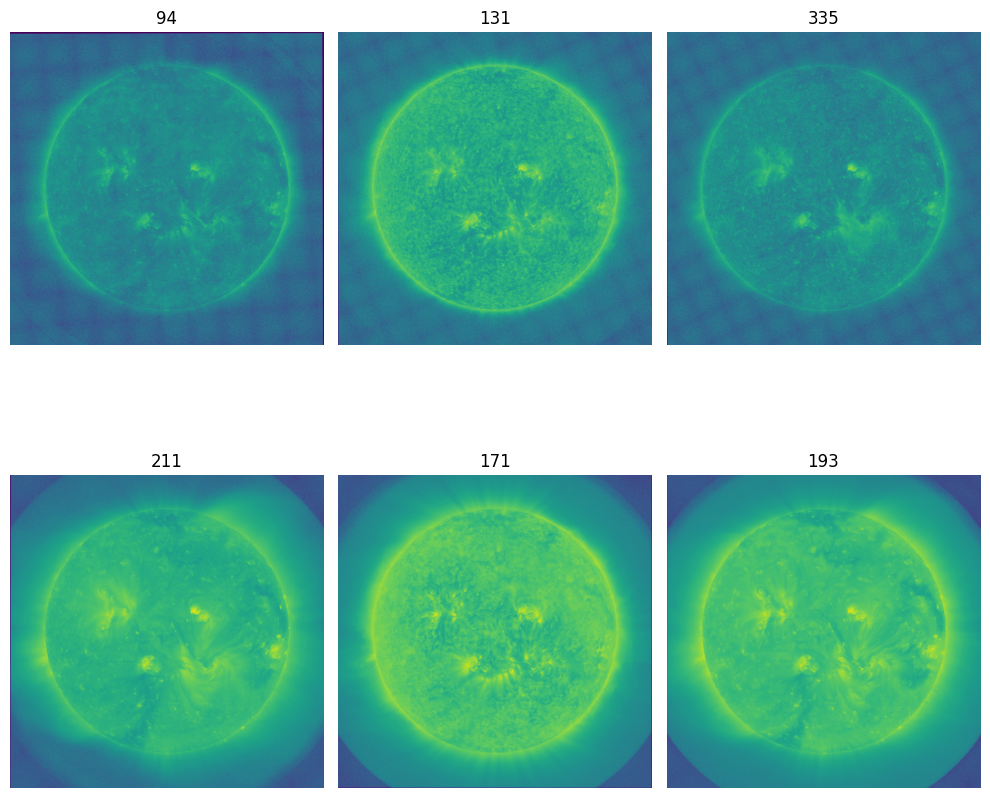

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,3, figsize=(10,10))

for axes , m in zip(ax.flatten(),sdo_prep):
  axes.imshow(m.data**0.1)
  axes.axis('off')
  axes.set_title(m.meta['wavelnth'])

plt.tight_layout()

In [ ]:
# save to compressed fits files
from astropy.io import fits

for m, wv in zip(sdo_prep, wvn):
    hdu = fits.CompImageHDU(m.data, m.fits_header)
    hdu.writeto('/content/drive/MyDrive/sdo_cor_hole_data/{0}/aia_prep_decon{1}.fits'.format(date,wv), overwrite=True)

In [ ]:
aia_map = Map('/content/drive/MyDrive/sdo_cor_hole_data/2010-05-23/aia_prep_decon171.fits')

In [ ]:
for m, wv in zip(sdo_prep, wvn):
  m.save('/content/drive/MyDrive/sdo_cor_hole_data/{0}/aia_prep_decon{1}.fits'.format(date,wv), overwrite=True)